In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [2]:
%run ./initialize.ipynb

Imported function `get_value_data(files, columns)` -> dataframe of values
Imported function `get_value_data(files, columns)` -> dataframe of returns
Imported function `initialize_data()` -> tuple of value and returns data
Imported class `Arbitrage(data : pd.DataFrame)` with methods `show_plot()`, `get_test_results()`


In [3]:
data = initialize_data()
df = data.get_ffill_data()
returns = data.get_true_return().dropna()
returns.head()

,us_agg,jpy,global_agg,gb,em_agg,ger,euro_agg,us
Date,,,,,,,,
2000-11-08,0.000624,-0.00005,-0.002368,0.000037,-0.005770,0.00010,-0.000192,-0.00011
2000-11-09,0.001960,-0.00010,0.002085,-0.000163,0.000349,-0.00021,0.000474,-0.00030
2000-11-10,0.000122,0.00004,0.000937,-0.000228,0.005363,-0.00009,0.000713,-0.00042
2000-11-13,0.002067,-0.00028,0.001797,-0.000358,0.003666,-0.00034,0.003032,-0.00017
2000-11-14,0.000787,0.00006,-0.001735,0.000177,0.002980,0.00002,-0.000744,-0.00011


In [4]:
total_return_df = df[['us_agg', 'global_agg', 'em_agg', 'euro_agg']]
yield_df = df[['jpy', 'gb', 'ger', 'us']]

In [102]:
def get_rolling_volatilities(data, rolling_period = 20):
    return data.rolling(rolling_period).std().dropna()

def rank_volatilities(volatility_data):
    from scipy.stats import percentileofscore
    percentiles = volatility_data.apply(lambda x: percentileofscore(volatility_data, x))
    return percentiles

def high_volatility_market(volatility_data):
    ranks = rank_volatilities(volatility_data)
    return 1 if ranks[-1] > 90 else 0    

## Build rough strategy
Idea: Long most volatile after high volatility market

In [20]:
class Portfolio:
    
    def __init__(self, asset_returns, weights):
        
        self.weights = weights
        self.asset_returns = asset_returns
        self.returns = (self.weights * self.asset_returns).sum(axis = 1)
        
    def plot(self):
        (self.returns + 1).cumprod().plot()

In [107]:
class Test:
    
    def __init__(self, data):
        
        self.data = data.copy()
        self.asset_rtn = data.apply(to_stationary, axis = 0)
        
        self.__ew = data.copy().applymap(lambda x : 1 / len(data.columns))
        self.ew_portfolio = Portfolio(self.asset_rtn, self.__ew)
        
        self.positions = self.data.applymap(lambda x: 0)
        
        rolling_volatilities = get_rolling_volatilities(self.ew_portfolio.returns, 20).dropna()
        self.high_volatility = rolling_volatilities.rolling(252).apply(high_volatility_market).dropna()
        self.rolling_asset_vol = get_rolling_volatilities(self.asset_rtn, 20).dropna()

    
    def __backtest__(self):

        lagged_rolling_vol = self.rolling_asset_vol.shift()

        def find_positions(volatile_flag):
            enter, exit = [], []
            stack = []
            current_period = 0
            for date, value in volatile_flag.items():
                previous_highvol = len(list(filter(lambda x : x == 1, stack)))
                current_period += 1
                if previous_highvol == 3 and value == 0:
                    enter.append(date)
                    current_period = 0
                elif len(enter) > len(exit) and value == 1:
                    exit.append(date)
                    current_period = 0
                elif len(enter) > len(exit) and current_period > 40:
                    exit.append(date)
                    current_period = 0

                if len(stack) == 3: stack.pop(0)
                stack.append(value)

            return [(ent, ex) for ent, ex in zip(enter, exit)]

        positions = find_positions(self.high_volatility)        
        for entrance, exit in positions:
            period = lagged_rolling_vol.loc[entrance : exit]
            for date, values in period.iterrows():
                most_vol = values.idxmax()
                assets = len(self.positions.columns)
                self.positions.loc[date] = [-1 / (assets - 1)] * assets
                self.positions.loc[date].loc[most_vol] = 1
                
        self.strategy = Portfolio(self.asset_rtn, self.positions)
        self.overlay = Portfolio(self.asset_rtn, self.positions + self.__ew)

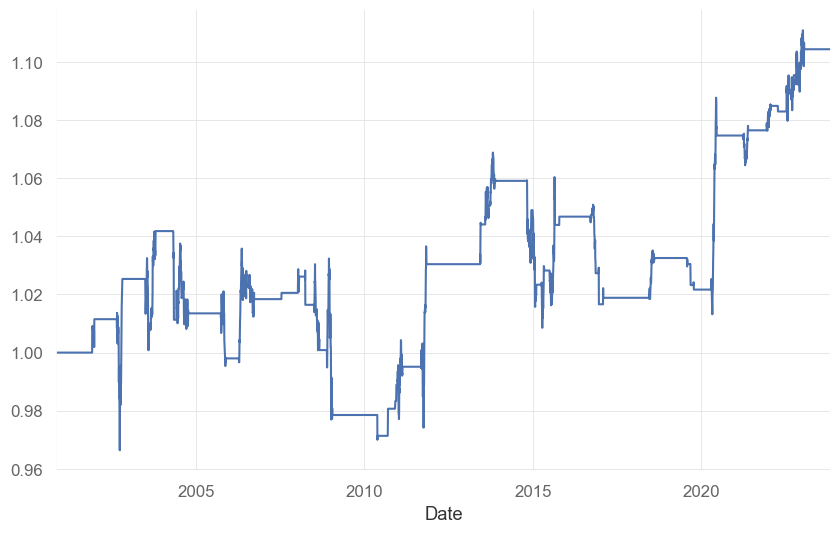

In [108]:
item = Test(total_return_df)
item.__backtest__()
item.strategy.plot()

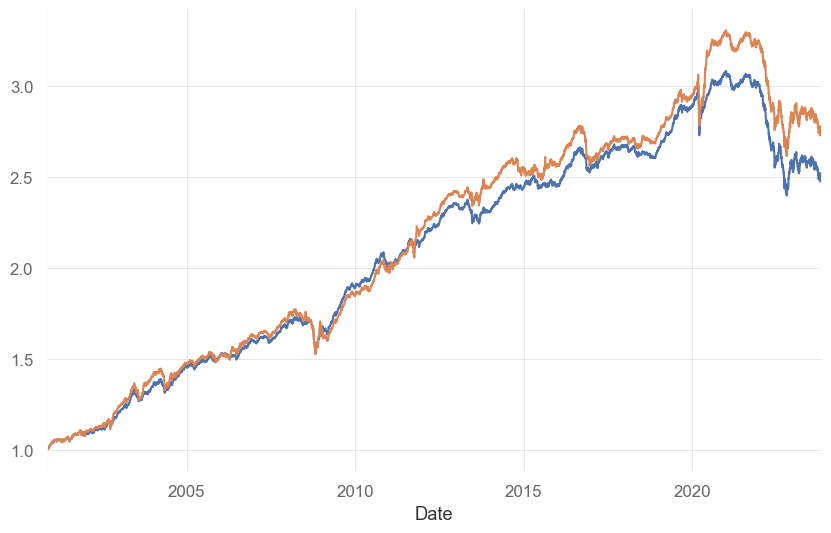

In [110]:
item.ew_portfolio.plot()
item.overlay.plot()

In [112]:
# almost completely market neutral (no correlation with market) 
item.strategy.returns.corr(item.ew_portfolio.returns)

0.10509890981383428

### Note: This can and should be extended via a GARCH model, such that we can anticipate volatile markets and decreasing of volatile markets to make more precise L/S positions